<a href="https://colab.research.google.com/github/NClaudiu77/Plant-Pathology/blob/main/Cassava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=50f0d6a9f14cdedf283adc276952555215a030f9fedd9fb2887cca7a5cd45e89
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"negreaclaudiu","key":"414b3b4f314a0eec132b78a5db10599c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




**Download the data and unzip it**



In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [02:09<00:00, 26.3MB/s]
100% 5.76G/5.76G [02:09<00:00, 47.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/cassava-leaf-disease-classification.zip", 'r')
zip_ref.extractall('sample_data')
zip_ref.close()

In [ ]:
# Import needed packages

import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
# Define our hyperparameters

BATCH_SIZE = 8
IMG_SIZE = 512
EPOCHS = 10


In [ ]:
# Reading images path and their labels
train_images = '/content/sample_data/train_images'
data_df = pd.read_csv("/content/sample_data/train.csv")
# Shuffle data
data_df = data_df.sample(frac = 1)
data_df['path'] = train_images + "/" + data_df['image_id']
# Convert labels from string to int
data_df['label'].values.astype(int)
data_df.head()

total_samples = len(data_df)

In [ ]:
#Our labels distribution
data_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
# classes that correspond to these labels
!cat '/content/sample_data/label_num_to_disease_map.json'

{"0": "Cassava Bacterial Blight (CBB)", "1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", "3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}


In [ ]:
#one-hot encode for labels
labels = to_categorical(data_df['label'])


In [ ]:
# construct the dataset (imagePath + its label)
data = tf.data.Dataset.from_tensor_slices((data_df.path.values, labels))


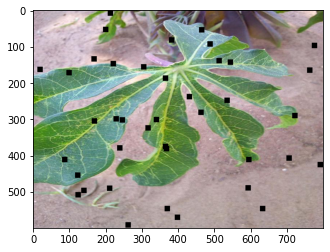

In [ ]:
import random
# defined an cutout function for images
def cutout(image, num_holes = 20, hole_size = 10):
    img = np.array(image)
    img_height, img_width = img.shape[:-1]
    
    for i in range(num_holes):    
        x = random.randint(0,img_height-hole_size)
        y = random.randint(0,img_width-hole_size)
        img[x:x+hole_size , y:y+hole_size,:] = 0 
    return img

img = Image.open("/content/sample_data/train_images/1004826518.jpg")



img  = cutout(np.array(img), 40, 15)
plt.imshow(img)
plt.show()

In [ ]:
# function which return image and its label from its paths
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [512, 512], method = 'nearest')
    img = tf.image.random_brightness(img, 0.3, seed=42)
    #img = tf.image.random_contrast(img, 0, 0.1, seed=42)
    #img = tf.image.random_hue(img, 0.1)
    #img = tf.numpy_function(cutout, [img], tf.uint8)
    return img, label
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [ ]:
# mapping the function on the original dataset which consist from images path
data = data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

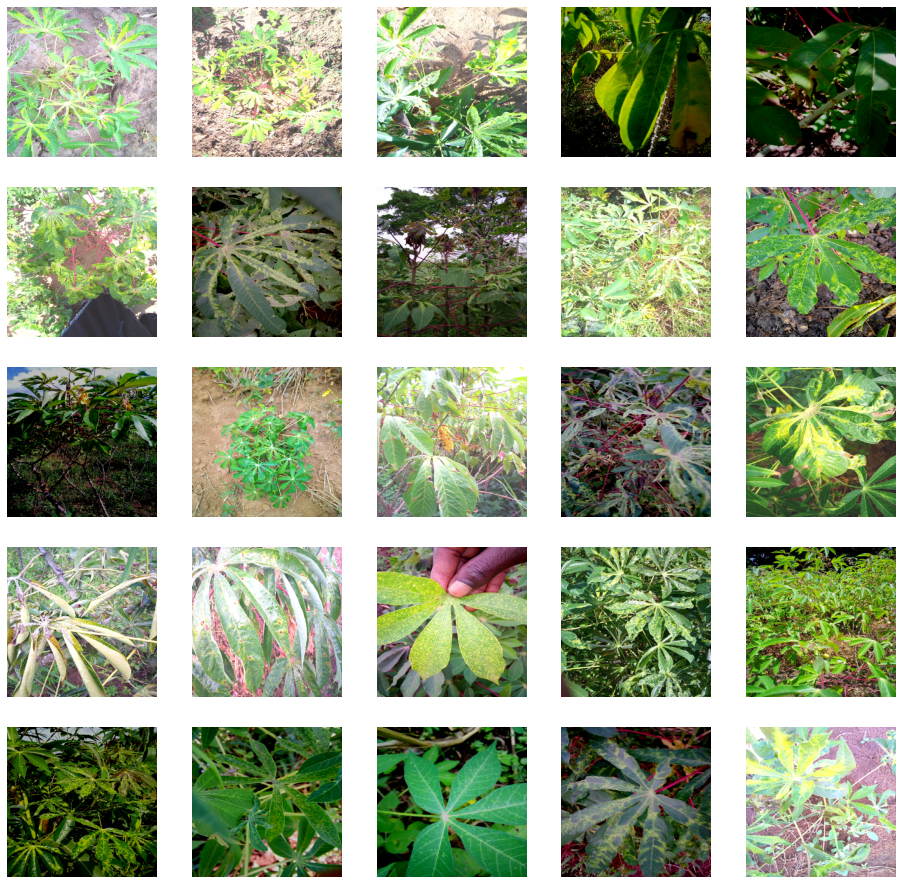

In [ ]:
# Visualize some data images
i = 0
plt.figure(figsize=(16, 16))
for im in data.take(25):
  ax = plt.subplot(5, 5, i + 1)
  i += 1
  plt.imshow(im[0])
  plt.axis("off")

In [ ]:

# Define some more data augmentations

augmentations = Sequential(
    [  
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((0.0, 0.2)),
        layers.experimental.preprocessing.RandomContrast((0.0,0.2)),
        layers.experimental.preprocessing.RandomRotation(factor=(-0.1, 0.1)),
        layers.experimental.preprocessing.RandomTranslation( height_factor = (-0.1, 0.1),  width_factor = (-0.1, 0.1)),
        #layers.experimental.preprocessing.RandomCrop(IMG_SIZE, IMG_SIZE)
    ]
)

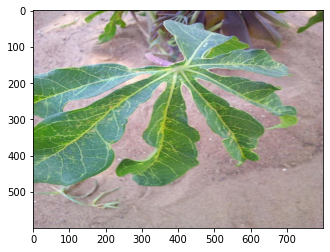

In [ ]:
#Visualize an image without any augmentations
original_img = Image.open("/content/sample_data/train_images/1004826518.jpg")
plt.imshow(original_img)
plt.show()

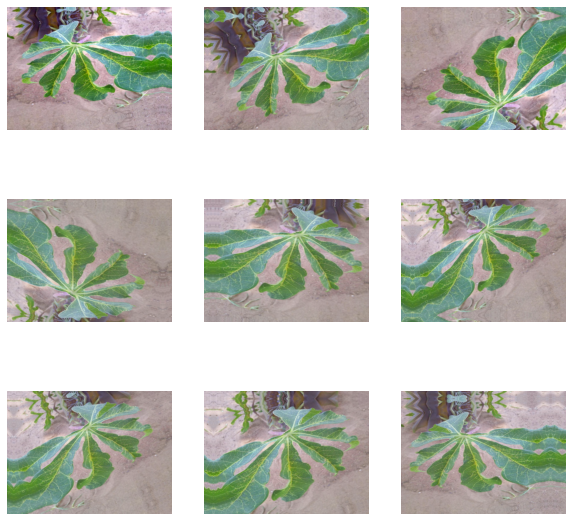

In [ ]:
# Now, lets see it with some augmentations
original_img = tf.expand_dims(np.array(original_img), 0)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = augmentations(original_img)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
# Download the convolutional base, in our case EfficientNetB3
conv_base = EfficientNetB3(include_top = False, weights = 'imagenet', input_shape = (IMG_SIZE, IMG_SIZE, 3), drop_connect_rate=0.4)

43941888/43941136 [==============================] - 0s 0us/step


In [ ]:
# This CNN have an Normalization layer, which correspond to ImageNet, we need to adjust it
norm_layer = conv_base.layers[2].name
norm_layer

'normalization'

In [ ]:
# Change the layer parameters to mean, std calculated on our dataset
conv_base.get_layer(norm_layer).set_weights( [np.array([0.42580798, 0.4968467 , 0.3084387 ], dtype = np.float32),np.array([0.05642978, 0.05777279, 0.05193274], dtype = np.float32), np.int64(10279560000)] ) 

In [ ]:
# Define our LR scheduler
decay_steps = int(total_samples / BATCH_SIZE)* EPOCHS
cosine_decay = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.2)
#Define our optimizer
adam = tf.keras.optimizers.Adam(cosine_decay)
#Define some callbacks, in this case, EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)

#Define our loss
loss = tf.keras.losses.categorical_crossentropy


In [ ]:
# define a fct to build the model from an conv base
def make_model(conv_base):
    inputs = conv_base.input 
    aug = augmentations(inputs)
    effnetoutput = conv_base(aug)
    pooling = layers.GlobalAveragePooling2D()(effnetoutput)
    dropout = layers.Dropout(0.5)(pooling)
    dense = layers.Dense(128, activation = 'relu')(dropout)
    outputs = layers.Dense(5, activation = 'softmax')(dense)
    
    return Model(inputs, outputs)
    

In [ ]:
# The architecture of our model
model = make_model(conv_base)
model.compile(optimizer = adam , loss = loss, metrics = ['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645 

In [ ]:
# Seeing the GPU
!nvidia-smi

Thu Feb 11 13:20:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |    291MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Epoch 1/10
2140/2140 [==============================] - 1987s 894ms/step - loss: 0.7712 - accuracy: 0.7136 - val_loss: 0.4586 - val_accuracy: 0.8362
Epoch 2/10
2140/2140 [==============================] - 1960s 893ms/step - loss: 0.4721 - accuracy: 0.8357 - val_loss: 0.4320 - val_accuracy: 0.8521
Epoch 3/10
2140/2140 [==============================] - 1961s 893ms/step - loss: 0.4139 - accuracy: 0.8568 - val_loss: 0.3995 - val_accuracy: 0.8640
Epoch 4/10
2140/2140 [==============================] - 1953s 890ms/step - loss: 0.3829 - accuracy: 0.8667 - val_loss: 0.4122 - val_accuracy: 0.8600
Epoch 5/10
2140/2140 [==============================] - 1953s 890ms/step - loss: 0.3495 - accuracy: 0.8781 - val_loss: 0.4113 - val_accuracy: 0.8640
Epoch 6/10
2140/2140 [==============================] - 1959s 893ms/step - loss: 0.3290 - accuracy: 0.8858 - val_loss: 0.4459 - val_accuracy: 0.8602
Epoch 7/10
2140/2140 [==============================] - 1961s 893ms/step - loss: 0.3028 - accuracy: 0.8943

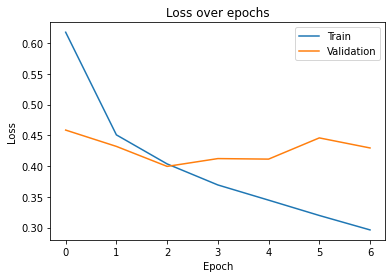

In [ ]:

# K-fold validation

K = 5
num_val_samples = total_samples //  K

for i in range(1):
  model = make_model(conv_base)
  model.compile(optimizer = adam , loss = loss, metrics = ['accuracy'])

  # validation data
  val_data = data.skip(i*num_val_samples).take(num_val_samples)
  val_data_batches = val_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


  # train_data
  train_data =  data.take(i*num_val_samples).concatenate(data.skip((i+1)*num_val_samples))
  train_data_batches = train_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

  history = model.fit(train_data_batches,
                  epochs = EPOCHS, 
                  validation_data = val_data_batches,
                  callbacks = early_stop)
  
  #plot the loss and val_loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss over epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.show()

In [ ]:
# train data batches
data_batches = data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# predict on train
predictOnTraining = model.predict(data_batches)

In [ ]:
# get the prediction classes
pred = np.argmax(predictOnTraining, axis = -1)

In [ ]:
ground_truth = data_df['label'].values

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
# get the accuracy
acc = accuracy_score(ground_truth, pred)
# compute confusion matrix
conf_mat = confusion_matrix(ground_truth, pred)

print("Accuracy: " + str(acc))

Accuracy: 0.9132121325419451


In [ ]:
# Normalize confusion matrix
norm = np.zeros(shape = (5, 5))
for i in range(5):
    for j in range(5):
        norm[i][j] = conf_mat[i][j]/np.sum(conf_mat[i, :])

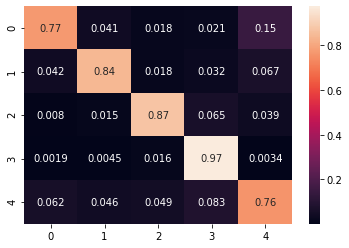

In [ ]:
import seaborn as sns
sns.heatmap(norm, annot = True)

**What does our CNN see?**

In [ ]:
img = Image.open("/content/sample_data/train_images/1004105566.jpg")

In [ ]:
# last conv block
layer_outputs = model.layers[-5].output
# get the last conv block output
activation_model = Model(inputs = model.input, outputs = layer_outputs) 

#random crop from initial image
img =  layers.experimental.preprocessing.RandomCrop(IMG_SIZE, IMG_SIZE)(tf.expand_dims(np.array(img), 0))
# get the activations
activations = activation_model.predict(img) 

In [ ]:
activations.shape

(1, 16, 16, 1792)

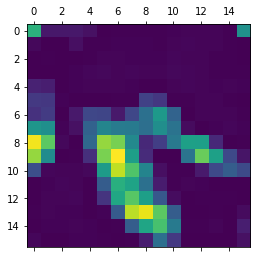

In [ ]:
plt.matshow(activations[0][:, :, 106], cmap ='viridis') 

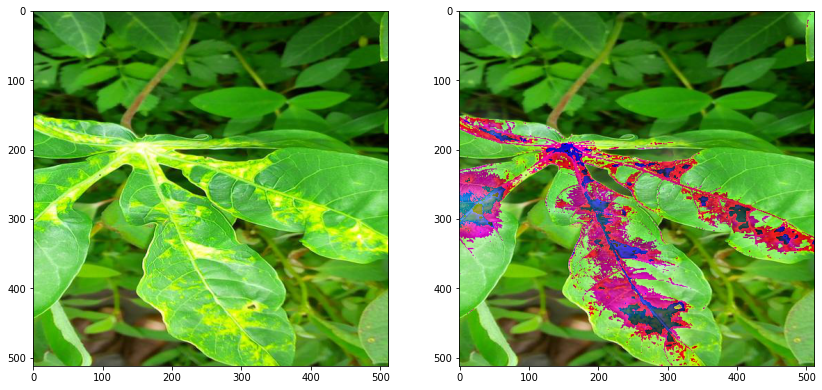

In [ ]:
import cv2
new_img = img[0]
for i in range(0, 300, 3):
   heatmap = activations[0][:, :, i:i+3]
   heatmap = cv2.resize(heatmap, (512, 512))
   new_img = 0.5  * heatmap + new_img

plt.figure(figsize =  (14, 14))
ax = plt.subplot(1, 2, 1)
plt.imshow(img[0])

ax = plt.subplot(1, 2, 2)
plt.imshow(new_img)